In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation
import meshio

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight"}
plt.rcParams.update(params)

%matplotlib inline

In [2]:
g = 9.81  # m/s²
v0 = 5  # m/s
T = 2 * v0 / g
t = np.linspace(0, T, 100)
uz = v0 * t - 0.5 * g * t ** 2

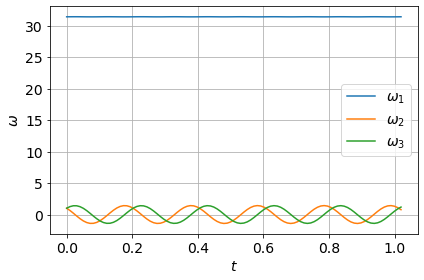

In [3]:
m = 0.2
L, B, H = 0.2, 0.1, 0.01
I = 1 / 12 * m * np.array([L ** 2 + B ** 2, L ** 2 + H ** 2, B ** 2 + H ** 2])

def domega_dt(t, omega):
    return np.vstack([
        (I[1] - I[2]) / I[0] * omega[1] * omega[2],
        (I[2] - I[0]) / I[1] * omega[2] * omega[0],
        (I[0] - I[1]) / I[2] * omega[0] * omega[1]
    ])

omega0 = np.array([10 * np.pi, 1, 1])

res = solve_ivp(
    domega_dt, (0, T), omega0, max_step=T / 100, dense_output=True, vectorized=True)
omega = res.sol

for i in range(len(omega0)):
    plt.plot(res.t, res.y[i], label=f"$\omega_{i + 1:d}$")
plt.xlabel("$t$")
plt.ylabel("$\omega$")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("omega_1.svg")

def dq_dt(t, q):
    q[:] = q / np.linalg.norm(q)
    omega1, omega2, omega3 = omega(t)
    dqdt = 0.5 * np.array([[0, omega3, -omega2, omega1],
                           [-omega3, 0, omega1, omega2],
                           [omega2, -omega1, 0, omega3],
                           [-omega1, -omega2, -omega3, 0]]) @ q
    return dqdt

q0 = np.array([0, 0, 0, 1])
res = solve_ivp(
    dq_dt, (0, T), q0, max_step=T / 100, dense_output=True)
q = res.sol

mesh = meshio.read("box.stl")
with meshio.xdmf.TimeSeriesWriter("box_1.xdmf") as writer:
    writer.write_points_cells(mesh.points, mesh.cells)
    for i in range(len(t)):
        R = Rotation.from_quat(q(t[i])).as_matrix()
        u = mesh.points @ (R - np.eye(3)).T
        u[:, 2] += uz[i]
        writer.write_data(t[i], point_data={"Displacement": u})

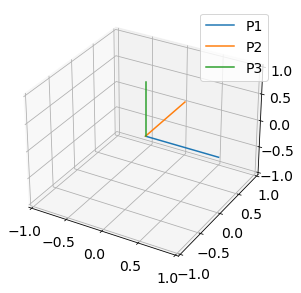

In [20]:
def plot_rotation(t):
    from mpl_toolkits import mplot3d

    R = Rotation.from_quat(q(t)).as_matrix()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    for i in range(3):
        ax.plot([0, R[0, i]], [0, R[1, i]], [0, R[2, i]], label=f"P{i + 1:d}")
    ax.legend()
    ax.set_zlim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    fig.tight_layout()

plot_rotation(0)